# RNA - Operação de Crédito

Teste de uma RNA aplicada a classificação de documentos da operação de crédito. Os textos foram extraídos de documentos encaminhados pelos municípios, os arquivos foram convertidos para imagens (JPEG) e então tiveram seu texto extraído através de um OCR (tesseract).

O tipo do documento é considerado como classe alvo. Foi observado que alguns tipos de documentos sofreram alteração em seu nome, fazendo necessário a adequação do tipo de documento antes da classificação.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn

from text.process import text_processor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [2]:

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [59]:
RANDOM_STATE = 42
DATAFRAME_PATH = '/home/cti/workspace/cls_documento/dataset/dataframe/dataframe_operacao_credito.csv'


df = pd.read_csv(DATAFRAME_PATH)

# Remove documentos da parte técnica
# df = df[ (df['tipo'] != 'Características técnicas') & (df['tipo'] != 'Planilha de orçamento - Ganhadora') & (df['tipo'] != 'Edital de classificação')] 

df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Anexo 01 da LOA' else 'Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado')
df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Certidão do TCE-PR' else 'Certidão do TCE-PR – Especifica para Operação de Crédito')
df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Certidão negativa da Secretaria de Estado da Fazenda do Paraná' else 'Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito')


df.dropna()

df['texto'] = df['texto'].astype(str).apply(lambda x: x.replace("\n", " "))
df['texto_limpo'] = df['texto'].astype(str).apply(text_processor.clear_words)
df['texto_stemmed'] = df['texto_limpo'].astype(str).apply(text_processor.stem_sentence)
df['texto_len'] = df['texto'].astype(str).apply(len)
df['texto_limpo_len'] = df['texto_limpo'].astype(str).apply(len)
df['texto_stemmed_len'] = df['texto_stemmed'].astype(str).apply(len)
df['qtd_palavras_texto'] = df['texto'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_limpo'] = df['texto_limpo'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_stemmed'] = df['texto_stemmed'].apply(lambda x: len(str(x).split()))

n_classes = len(df.tipo.unique())

df.sample(5)

Unnamed: 0                                       projeto  \
27           27                Anahy - Operação de Crédito 18   
341         341           Terra Rica - Operação de Crédito 25   
318         318  São João do Triunfo - Operação de Crédito 13   
56           56          Borrazópolis - Operação de Crédito 8   
36           36   Bom Sucesso do Sul - Operação de Crédito 17   

                                                 texto  \
27   Prefeitura Municipal de Anahy        ESTADO DO...   
341  ANEXO 01 DA LEI 4.320/64  DEMONSTRAÇÃO DA RECE...   
318  ESTADO DO PARANÁ  GABINETE DO PREFEITO  Enisã ...   
56   PREFEITURA MUNICIPAL DE BORRAZOPOLIS Estado do...   
36   Para aumentar tamanho da janeia, lque no botão...   

                                                  tipo            modulo  \
27                                    Lei Autorizadora  operacao_credito   
341  Anexo I da LOA – Anexo publicado junto à LOA d...  operacao_credito   
318                                   Lei Autorizadora  operacao_credito   
56   Anexo I da LOA – Anexo publicado junto à LOA d...  operacao_credito   
36   Certidão SEFA - Certidão Negativa para Obtençã...  operacao_credito   

                                           texto_limpo  \
27   prefeitura municipal anahy estado paraná rua v...   
341  anexo lei 320/64 demonstração receita despesa ...   
318  estado paraná gabinete prefeito enisã prefeitu...   
56   prefeitura municipal borrazopolis estado paran...   
36   aumentar tamanho janeia lque botão maximizar n...   

                                         texto_stemmed  texto_len  \
27   prefeit municip anahy est paran rua vere leona...      23433   
341  anex lei 320/64 demonstr receit desp segund ca...       1282   
318  est paran gabinet prefeit enisã prefeit munici...       3560   
56   prefeit municip borrazopolil est paran exerc 2...      13354   
36   aument tamanh jane lqu bot maxim naveg lmprim ...        954   

     texto_limpo_len  texto_stemmed_len  qtd_palavras_texto  \
27             17506              13159                3664   
341             1165                892                 161   
318             2586               1905                 554   
56              9743               7566                1942   
36               730                572                 152   

     qtd_palavras_texto_limpo  qtd_palavras_texto_stemmed  
27                       2094                        2094  
341                       133                         133  
318                       309                         309  
56                       1198                        1198  
36                         94                          94

In [62]:
# encoder = LabelEncoder()
encoder = OneHotEncoder(sparse=False)
X = df.texto_limpo.values
# X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values.reshape(len(df.tipo.values), 1))

# vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
# vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

input_dim = X_train.shape[1]

In [69]:

model = Sequential()
model.add(layers.Dense(8, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())


# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())


# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())

model.add(layers.Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 8)                 40008     
_________________________________________________________________
dropout_21 (Dropout)         (None, 8)                 0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 8)                 32        
_________________________________________________________________
dense_34 (Dense)             (None, 11)                99        
Total params: 40,139
Trainable params: 40,123
Non-trainable params: 16
_________________________________________________________________


In [70]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Train on 295 samples, validate on 74 samples
Epoch 1/50
295/295 [==============================] - 1s 4ms/step - loss: 2.1223 - acc: 0.3932 - val_loss: 2.3601 - val_acc: 0.4730
Epoch 2/50
295/295 [==============================] - 0s 118us/step - loss: 1.6758 - acc: 0.6305 - val_loss: 2.3220 - val_acc: 0.5270
Epoch 3/50
295/295 [==============================] - 0s 110us/step - loss: 1.5015 - acc: 0.7356 - val_loss: 2.2895 - val_acc: 0.5541
Epoch 4/50
295/295 [==============================] - 0s 162us/step - loss: 1.3592 - acc: 0.7898 - val_loss: 2.2620 - val_acc: 0.6486
Epoch 5/50
295/295 [==============================] - 0s 163us/step - loss: 1.2842 - acc: 0.8068 - val_loss: 2.2381 - val_acc: 0.7027
Epoch 6/50
295/295 [==============================] - 0s 149us/step - loss: 1.2049 - acc: 0.8203 - val_loss: 2.2180 - val_acc: 0.7027
Epoch 7/50
295/295 [==============================] - 0s 148us/step - loss: 1.2005 - acc: 0.8203 - val_loss: 2.1969 - val_acc: 0.7027
Epoch 8/50
295/295 

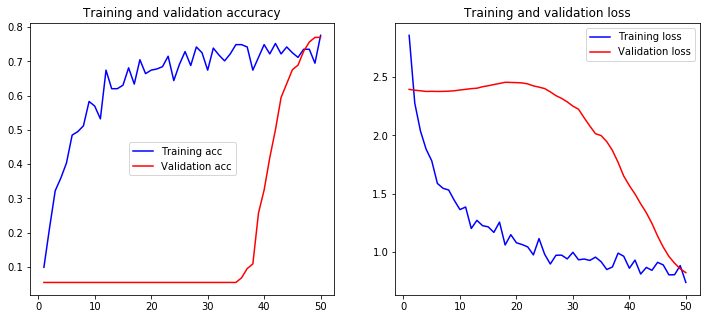

In [65]:
plot_history(history)

Acc Treino: 0.9831
Acc Teste:  0.9324


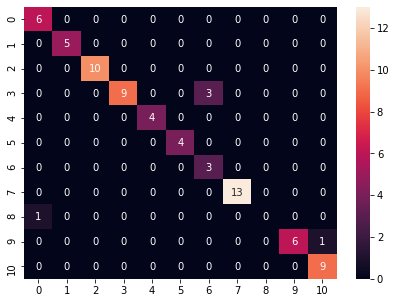

In [71]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Acc Teste:  {:.4f}".format(accuracy))


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


df_cm = pd.DataFrame(cm)
plt.figure(figsize = (7, 5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [72]:
index_test = 32
X_valid = df.iloc[index_test].texto_limpo
X_valid = vectorizer.transform([X_valid])

predicted = model.predict(X_valid)
print(predicted)
print(predicted.argmax(axis=-1))
print( encoder.inverse_transform(predicted) )
print(df.iloc[index_test].tipo)

[[1.6798029e-02 2.5325285e-02 8.1513455e-04 1.0900015e-03 8.2319713e-01
  1.9341607e-03 1.2095125e-02 2.7653724e-02 3.2837316e-02 4.8197996e-02
  1.0056108e-02]]
[4]
[['Ficha Cadastral e Ata de Posse do(a) Prefeito(a) Municipal']]
Ficha Cadastral e Ata de Posse do(a) Prefeito(a) Municipal


In [73]:

tipos = sorted(df.tipo.unique())

for tipo in sorted(tipos):
    print(tipo)
    encode = encoder.transform( np.array([tipo]).reshape(1, -1) )
    print(encode[0])


Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Certidão do TCE-PR – Especifica para Operação de Crédito
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Decreto de abertura de crédito adicional
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Ficha Cadastral e Ata de Posse do(a) Prefeito(a) Municipal
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Lei Autorizadora
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Lei abertura de crédito adicional
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Ofício de Indicação de Conta de Débito
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Outros - Operação de Crédito
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Parecer Jurídico
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Parecer Técnico
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
